# A Simple Mistral 7B Offline RAG with Reranker

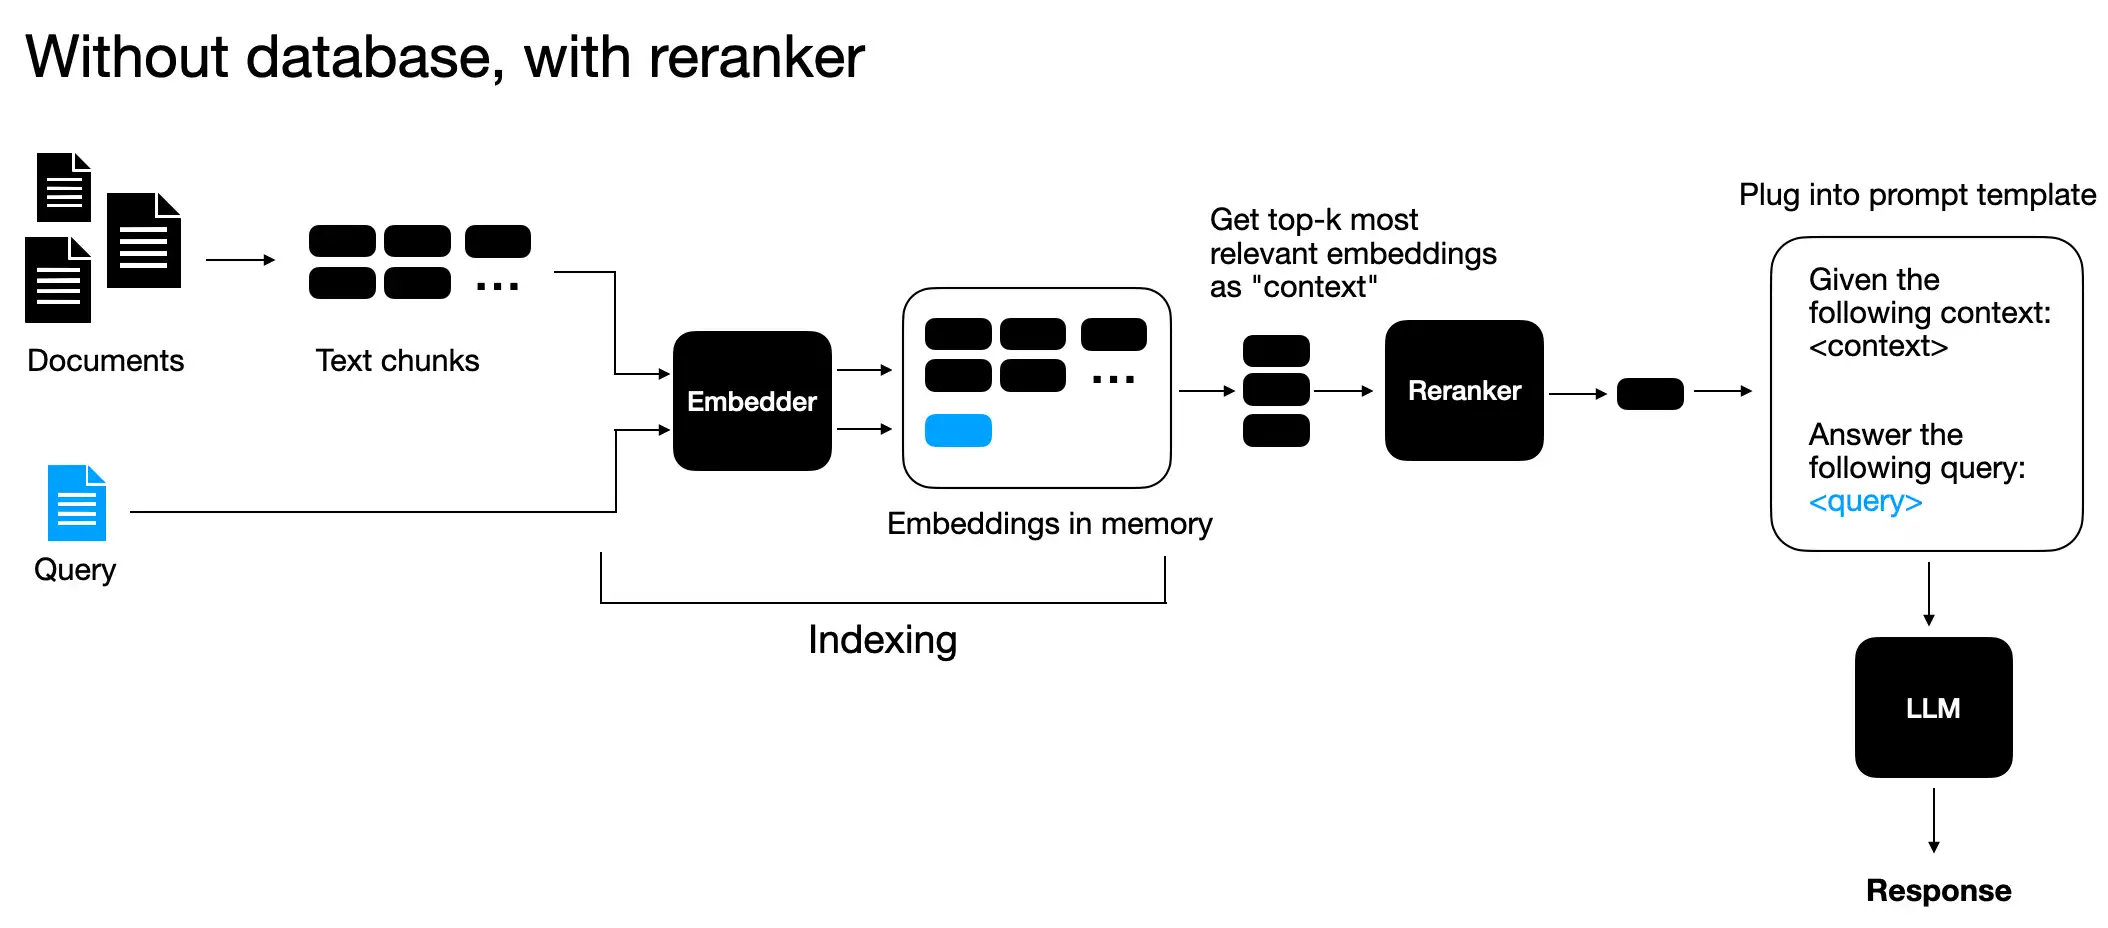

## 1) Load the embedding model and LLM:

In [ ]:
from llama_index.core import Settings, PromptTemplate
from llama_index.core.embeddings import resolve_embed_model
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM

import torch

Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

Settings.llm = HuggingFaceLLM(
    context_window=2048,
    max_new_tokens=256,
    generate_kwargs={"temperature": 0.25, "do_sample": False},
    model_name="mistralai/Mistral-7B-Instruct-v0.2",
    tokenizer_name="mistralai/Mistral-7B-Instruct-v0.2",
    device_map="auto",
    
    model_kwargs={
        "torch_dtype": torch.bfloat16,
        # Since we are using a small GPU with limited memory
        # Set to False if you have a large GPU to speed things up.
        "offload_buffers": True, 
    }
)

Settings.chunk_size = 512

## 2) Load data / read in documents

In [ ]:
from pathlib import Path
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

data_dir =  Path("RAGs") / "data" / "example-1"

documents = SimpleDirectoryReader(data_dir).load_data()

# Sanity checks
unique_docs = set(d.metadata["file_name"] for d in documents)
print(f"Read documents: {unique_docs}")

## 3) Create vector database

VectorStoreIndex is an in-memory vector database

In [ ]:
index = VectorStoreIndex.from_documents(
    documents,
    show_progress=True
)

num_chunks = len(documents)
print(f"Database consists of {num_chunks} chunks")

## 4) Set up query engine with reranker

In [ ]:
from llama_index.core.postprocessor import LLMRerank

query_engine = index.as_query_engine(
    similarity_top_k=6,
    node_postprocessors=[
        LLMRerank(
            choice_batch_size=3,
            top_n=2,
        )
    ],
    response_mode="tree_summarize",
)

## 5) Set up custom prompt template

In [ ]:
from llama_index.core import PromptTemplate

template = (
    "We have provided context information below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given this information, please answer the question: {query_str}\n"
)
qa_template = PromptTemplate(template)
query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": qa_template}
)